#### Metric function for Semantic segmentation

Semantic segmentation is essentially a classiciation task. Hence metrics used for classification are applicable. Following are some of the commonly used metrics for semantic segmentation:

- Pixel wise accuracy 
- Confusion matrix (specifies performance for each class)
- Dice coefficient (F1 score)
- Mean IoU (Intersection over Union) also reffered to as Jaccard Index or Jaccard metric. 

**We'll look at 2 commonly used metrics - pixel wise accuracy and meanIoU. mean IoU is preferred metric incase of imbalanced datasets**. We'll illustrate this with simple example as follows

## Basic imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# colab imports
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.chdir("/content/drive/My Drive/thinkAutonomous/image_segmentation/finalContent")

Mounted at /content/drive


## Sample Example for Imbalanced Dataset

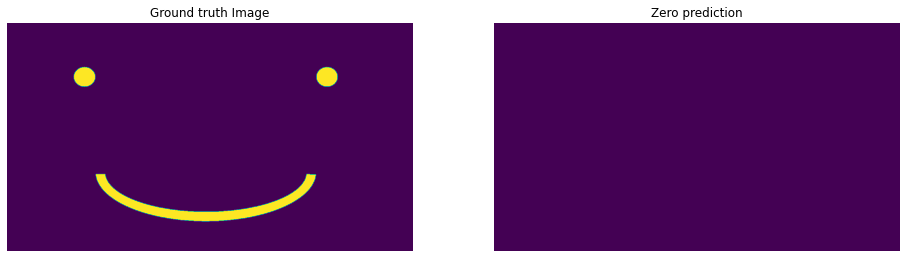

In [ ]:
demo_gt = np.load('dataset/metric_demo_gt.npy')
demo_preds = np.zeros_like(demo_gt)

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(16,6))
axes[0].imshow(demo_gt);
axes[0].set_title('Ground truth Image')
axes[0].axis('off');
axes[1].imshow(demo_preds);
axes[1].set_title('Zero prediction')
axes[1].axis('off');

In [ ]:
demo_gt.shape, np.unique(demo_gt)

((720, 1280), array([0, 1], dtype=uint8))

Without proper loss function, many models will simply predict the majority class as is the case above. In such cases, our metric should report a low value, considering no minority class is present in the predictions. We'll look how the two metrics give result

## Pixel wise accuracy

Its essentially the ratio of number of pixels we got right to the total number of pixels. 

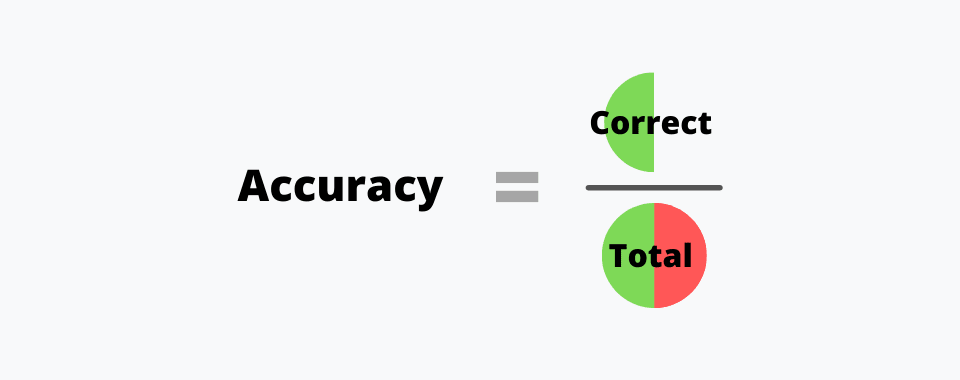

[Image reference](https://datascienceparichay.com/article/get-accuracy-of-predictions-in-python-with-sklearn/)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(demo_gt.flatten(), np.zeros_like(demo_gt).flatten())
print(f'Accuracy score = {accuracy * 100 : .2f}')

Accuracy score =  96.92


##Mean IoU in Semantic Segmentation

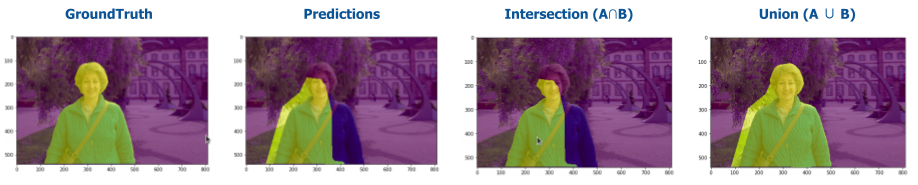


[Image reference](https://www.jeremyjordan.me/evaluating-image-segmentation-models/)

- IoU for a specific class can be described as the ratio of number of pixels where predictions match the groundtruth to total number of pixels for the class
- IoU can be calculated for each class over the entire test data
- Class wise IoU can be averaged to get the meanIoU.

In [ ]:
from sklearn.metrics import jaccard_score
meanIoU = jaccard_score(demo_gt.flatten(), np.zeros_like(demo_gt).flatten())
print(f'meanIoU score = {meanIoU * 100 : .2f}')

meanIoU score =  0.00


There are multiple ways and implementations to calculate the mean IoU metric. The below implementation ***maintains confusion matrix for all the classes and uses that to calculate class wise IoU which is averaged to find mean IoU***

In [ ]:
# Generally for semantic segmentation, 
###### Model predictions shape = (batch_size, num_classes, height, width)
###### Labels shape = (batch_size, height, width)

import torch 

class meanIoU:
    """ Class to find the mean IoU using confusion matrix approach """    
    def __init__(self, num_classes):
        self.iou_metric = 0.0
        self.num_classes = num_classes
        # placeholder for confusion matrix on entire dataset
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

    def update(self, y_preds, labels):
        """ Function finds the IoU for the input batch
        and add batch metrics to overall metrics """
        predicted_labels = torch.argmax(y_preds, dim=1)
        batch_confusion_matrix = self._fast_hist(labels.numpy().flatten(), predicted_labels.numpy().flatten())
        self.confusion_matrix += batch_confusion_matrix
    
    def _fast_hist(self, label_true, label_pred):
        """ Function to calculate confusion matrix on single batch """
        mask = (label_true >= 0) & (label_true < self.num_classes)
        hist = np.bincount(
            self.num_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.num_classes ** 2,
        ).reshape(self.num_classes, self.num_classes)
        return hist

    def compute(self):
        """ Computes overall meanIoU metric from confusion matrix data """ 
        hist = self.confusion_matrix
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        return iu, mean_iu

In [ ]:
# Create a probability tensor of shape (1,2, 720, 1280)
# where 1 = batch size, 2  = num_classes, (720, 1280) = image size
# we make the first channel (Class 0) 1 to make sure, argmax gives 0
zero_preds = np.zeros((1,2,720, 1280))
zero_preds[0, 0, :, :] = np.ones_like(demo_gt)
zero_preds = torch.from_numpy(zero_preds)
print("zero_preds.shape", zero_preds.shape)

zero_preds.shape torch.Size([1, 2, 720, 1280])


In [ ]:
# Sample function call
meanIoUObject = meanIoU(num_classes=2)

# add batch information to object
meanIoUObject.update(y_preds =zero_preds, labels = torch.from_numpy(demo_gt))

classwise_iou, mean_iou = meanIoUObject.compute()
print("classwise_iou = ", classwise_iou)
print("Mean IoU = ", mean_iou)

classwise_iou =  [0.96921766 0.        ]
Mean IoU =  0.48460883246527775



**References for Segmentation metrics**
- [torchvision utils](https://github.com/pytorch/vision/blob/main/references/segmentation/utils.py)
- [Segmentation metrics kaggle notebook](https://www.kaggle.com/yassinealouini/all-the-segmentation-metrics#Before-you-go)
- [Evaluating Image segmentation models](https://www.jeremyjordan.me/evaluating-image-segmentation-models/)
- [Segmentation metrics blog post](https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html)
- [torch ignite implementation](https://github.com/pytorch/ignite/blob/master/ignite/metrics/metric.py)
- [torch metrics](https://torchmetrics.readthedocs.io/en/latest/references/modules.html#iou)